In [86]:
from utils_csa import show_model_accuracy, save_obj, load_obj

import pandas.io.sql as psql
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score


# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc
import algocryptos_gridsearch as alg_gridsearch

from pprint import pprint

#np.set_printoptions(threshold='nan')

In [89]:
# ------------------ PARAMETERS ------------------ #
# ['y_+3h_value', 'y_+3h_classif',, 'y_+6h_value', 'y_+6h_classif', 'y_+12h_value', 'y_+12h_classif','y_+1d_value', 'y_+1d_classif', 'y_+2d_value', 'y_+2d_classif', 'y_+3d_value', 'y_+3d_classif', 'y_+7d_value', 'y_+7d_classif', 'y_+15d_value', 'y_+15d_classif', 'y_+30d_value', 'y_+30d_classif']
id_cryptocompare = "7605" # ether 7605
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
threshold = 0.7
dict_hours_labels  = {3:'3h', 6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}
only_one_crypto = False

In [88]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #

# ONE CRYPTO
#df = alg_preproc.get_global_dataset_for_crypto("236131")
#df2 = df.reset_index(drop=True)

# TOP N CRYPTOS
#dict_df = alg_preproc.get_global_datasets_for_top_n_cryptos(2)

# ------------------ LOAD DATA FROM FILE ------------------ #
# save_obj(dict_df, 'dict_df_2018_10_31')
dict_df = load_obj('dict_df_2018_10_26') # top 30-40 
#dict_df = load_obj('dict_df_2018_10_31') # top 10 
#dict_df = load_obj('dict_df_2018_11_07') # top 10 
#dict_df = load_obj('dict_df_2018_10_31_top2') # top 2

#dict_df.keys()

In [90]:
# ------------------ PRE-PROCESSING : Calcul y + split data ------------------ #
columns_nb = 0
df_new_dict = {}
df_new_list = []

def calcul_values_of_y(df, dict_hours_labels, increase_target_pct):
    increase_target_pct = increase_target_pct / 100
    
    for key in dict_hours_labels:
        label_value = 'y_+' + dict_hours_labels[key] + '_value'
        label_classif = 'y_+' + dict_hours_labels[key] + '_classif'
        # calcul several y searched (value)
        df[label_value] = df.close_price.shift(-key)
        
        # perform calcul to use binary classification
        df[label_classif] = ((df[label_value] - df['close_price']) / df['close_price']) > increase_target_pct
    
    return df

def do_split_data(df_p, columns_nb_p):
    # separe x,y
    X = df_p.iloc[:,range(1, columns_nb_p)]
    y = df_p.iloc[:,range(columns_nb_p, len(df_p.columns))]

    # split data in training / validating / testing
    return train_test_split(X, y, random_state=0, shuffle=False)

# calcul y for each crypto
for key_id_cryptocompare, df_one_crypto in dict_df.items():
    # number of columns before adding y values - could be done once only
    columns_nb = len(df_one_crypto.columns)

    # calcul all y values we are interested in and add it to the dataframe
    df_one_crypto = calcul_values_of_y(df_one_crypto.copy(), dict_hours_labels, close_price_increase_targeted)

    # remove rows where y can't be calculed (need more data in the future)
    df_one_crypto.dropna(subset=list(df_one_crypto.iloc[:,range(columns_nb, len(df_one_crypto.columns))]), inplace=True)
    
    df_new_dict[key_id_cryptocompare] = df_one_crypto
    df_new_list.append(df_one_crypto)

# concat to get only one dataframe instead of a list of dataframes
df_global = pd.concat(df_new_list).sort_index()
df_global.reset_index(drop=True)

# All cryptos
X_train, X_test, y_train, y_test = do_split_data(df_global, columns_nb)

if only_one_crypto:
    # The one to predict
    X_train_one_crypto, X_test_one_crypto, y_train_one_crypto, y_test_one_crypto = do_split_data(df_new_dict[id_cryptocompare], columns_nb)
    X_test = X_test_one_crypto
    y_test = y_test_one_crypto

# TODO : To be used to avoid overfitting : No tuning while using testing data, only validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# ------------------ PRE-PROCESSING : Scaling Data ------------------ #
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [ ]:
# -----------------------
# ALGO : RANDOM FOREST WITH RANDOMGRIDSEARCH
# -----------------------

rf_best_estimator, rf_best_params = alg_gridsearch.start_randomizedSearchCV_random_forest(X_train_scaled, 
                                                                                          y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', rf_best_estimator, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', rf_best_estimator, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

In [ ]:
# -----------------------
# ALGO : MLPC WITH RANDOMGRIDSEARCH
# -----------------------

mlpc_best_estimator, mlpc_best_params = alg_gridsearch.start_randomizedSearchCV_mlpc(X_train_scaled, 
                                                                                     y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', mlpc_best_estimator, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', mlpc_best_estimator, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   10.8s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:   10.9s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:   12.6s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:   14.1s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:   15.8s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   17.5s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:   19.1s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:   19.7s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:   20.1s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:   27.5s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   28.4s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:   28.7s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:   32.1s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:   35.5s
[Parallel(

[Parallel(n_jobs=3)]: Done 135 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done 136 tasks      | elapsed:  7.4min
[Parallel(n_jobs=3)]: Done 137 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 138 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 140 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 141 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 142 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 143 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 144 tasks      | elapsed:  7.6min
[Parallel(n_jobs=3)]: Done 145 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:  7.8min finished


[12:30:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 52 pruned nodes, max_depth=12
[12:30:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 52 pruned nodes, max_depth=12
[12:30:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 36 pruned nodes, max_depth=12
[12:30:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 30 pruned nodes, max_depth=12
[12:30:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 28 pruned nodes, max_depth=12
[12:30:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 22 pruned nodes, max_depth=12
[12:30:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:

f1=0.825 auc=0.937 ap=0.937


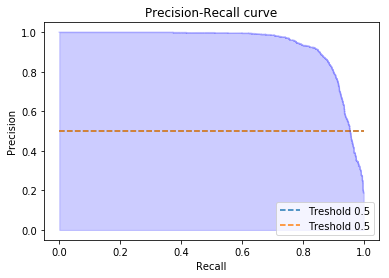

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[3411   55]
 [ 190   16]]
[[TN, FP]
[FN, TP]]
Accuracy: 0.93


Other Metrics :

              precision    recall  f1-score   support

       False       0.95      0.98      0.97      3466
        True       0.23      0.08      0.12       206

   micro avg       0.93      0.93      0.93      3672
   macro avg       0.59      0.53      0.54      3672
weighted avg       0.91      0.93      0.92      3672

----------------------------------------------------------

f1=0.116 auc=0.184 ap=0.183


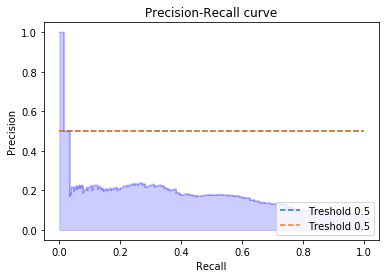

In [5]:
# -----------------------
# ALGO : XGBoost WITH RANDOMGRIDSEARCH
# -----------------------

xgboost_best_estimator, xgboost_best_params = alg_gridsearch.start_randomizedSearchCV_xgboost(X_train_scaled, 
                                                                                           y_train[y_to_be_considered],
                                                                                             n_iter = 30,)

show_model_accuracy('GradientBoostingClassifier - Train', xgboost_best_estimator, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('GradientBoostingClassifier - Test', xgboost_best_estimator, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

In [ ]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------

from sklearn.ensemble import RandomForestClassifier
#, n_estimators=100, max_features='auto', max_depth=5, criterion='entropy', class_weight="balanced"
# clf = RandomForestClassifier(random_state=0, class_weight="balanced", bootstrap=False,
#  criterion='entropy',
#  max_depth=5, #5
#  max_features='auto',
#  min_samples_leaf=4,
#  min_samples_split=10,
#  n_estimators=83).fit(X_train_scaled, y_train[y_to_be_considered])

clf = RandomForestClassifier(n_estimators=50, max_features='auto', max_depth=5, criterion='entropy', class_weight={0:1,1:7}, random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)

# proba : to be shown by prediction, bien comprendre !
probas = clf.predict_proba(X_test_scaled)[:,1]
pprint(np.sort(probas))
y_test[y_to_be_considered].describe()
y_train[y_to_be_considered].describe()
#pprint(clf.get_params())

In [ ]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [130, 130], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False, threshold=threshold)

# proba : to be shown by prediction, bien comprendre !
#print(pd.DataFrame(nnclf.predict_proba(X_test_scaled)[:,1]))

----------------------------------------------------------
Results for algorithm : XGBClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[111010    320]
 [ 25223   5875]]
[[TN, FP]
[FN, TP]]
Accuracy: 0.82


Other Metrics :

              precision    recall  f1-score   support

       False       0.81      1.00      0.90    111330
        True       0.95      0.19      0.32     31098

   micro avg       0.82      0.82      0.82    142428
   macro avg       0.88      0.59      0.61    142428
weighted avg       0.84      0.82      0.77    142428

----------------------------------------------------------



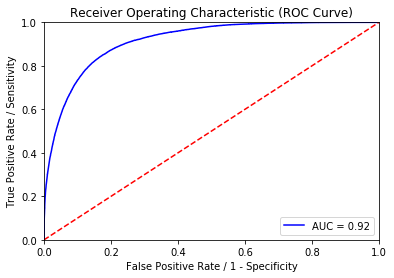

f1=0.613 auc=0.771 ap=0.771


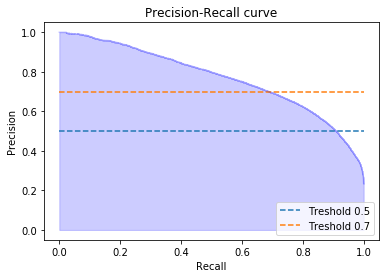

----------------------------------------------------------
Results for algorithm : XGBClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[41095    43]
 [ 6042   296]]
[[TN, FP]
[FN, TP]]
Accuracy: 0.87


Other Metrics :

              precision    recall  f1-score   support

       False       0.87      1.00      0.93     41138
        True       0.87      0.05      0.09      6338

   micro avg       0.87      0.87      0.87     47476
   macro avg       0.87      0.52      0.51     47476
weighted avg       0.87      0.87      0.82     47476

----------------------------------------------------------



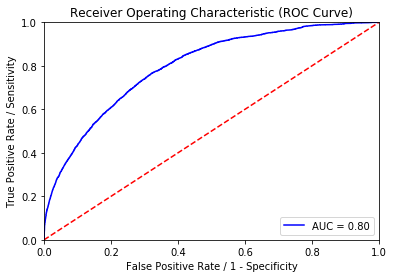

f1=0.287 auc=0.431 ap=0.432


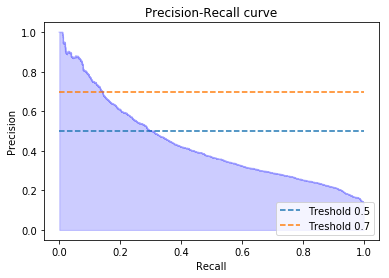

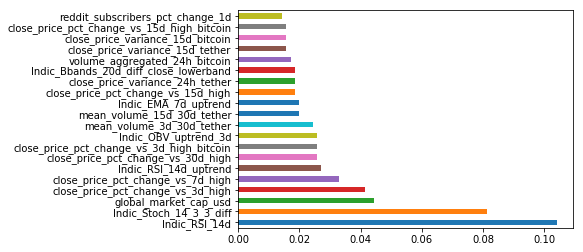

In [91]:
# -----------------------
# ALGO : XGBOOST (cf. Module+4 for tuning)
# -----------------------
from xgboost import XGBClassifier

xgbc = XGBClassifier().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('XGBClassifier - Train', xgbc, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=False, threshold=threshold)
show_model_accuracy('XGBClassifier - Test', xgbc, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_precision_recall_curve=True, do_features_importance=True, threshold=threshold)

xgbc.get_params()

In [92]:
xgbc.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [80]:
mon_xgb = start_SearchCV_xgboost(X_train_scaled, y_train[y_to_be_considered])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:    5.0s
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:    9.5s
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:    9.6s
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:   12.2s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   17.3s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:   17.4s
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:   20.2s
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:   25.7s
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:   29.4s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   31.9s
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:   37.7s
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:   41.3s
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:   43.9s
[Parallel(

In [79]:
import pandas as pd
import numpy as np

from pprint import pprint

from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# -----------------------
# RANDOMGRIDSEARCH: XGBOOST CLASSIFIER
# -----------------------
# https://xgboost.readthedocs.io/en/latest/parameter.html
# http://danielhnyk.cz/how-to-use-xgboost-in-python/
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def start_SearchCV_xgboost(X_train, y_train, 
                                          cv = 5, verbose=20, n_jobs = 3): #n_jobs = -1
    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)]
    
    # TODO : A paramétrer proprement
#     random_grid = {
#     'n_estimators':n_estimators,
#     'max_depth':max_depth,
#     'booster':['gbtree', 'gblinear', 'dart'],
#     'min_child_weight':[2,3,4,5],
#     'colsample_bytree':[0.2,0.6,0.8],
#     'colsample_bylevel':[0.2,0.6,0.8]
# }
    #'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    random_grid = {
    #'max_depth': [3, 12, 20],
    'n_estimators': n_estimators
    #'subsample': [0.5, 0.7, 1.0],
    #'min_child_weight':[0.5, 1.0, 5.0, 10.0],
    #'colsample_bytree': [0.2, 0.5, 1.0],
    #'colsample_bylevel': [0.2,0.5, 1.0],
    #'gamma': [0, 0.25, 0.5, 1.0],
    #'reg_alpha': [0],
    #'reg_lambda': [0.1, 1.0, 10.0, 50.0]
}
    
    
    scorers = {
            'precision_score': make_scorer(precision_score)
        }

    xgb = XGBClassifier()
    xgb_random = GridSearchCV(estimator = xgb, param_grid = random_grid, cv = cv, verbose=verbose, n_jobs = n_jobs,
                                      scoring=scorers, refit='precision_score')

    xgb_random.fit(X_train, y_train)
    #return xgb_random.best_estimator_, xgb_random.best_params_
    return xgb_random